# DustPy – Advanced modifications

The power of using Simframe for dust evolution with DustPy is that every aspect of the simulation can be easily customized. This will be demonstrated in this notebook.  
Additionally, this notebook will demonstrate how to customize the initial surface densities.

There has been the idea that the fragmentation velocity can depend on the composition of the dust grains, with particles covered in water ice being more sticking and able to withstand high velocity impacts (see [Gundlach & Blum, 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...798...34G/abstract)). The goal of this notebook is to implement a fragmentation velocity that depends on the temperature assuming that particles are ice-free if the temperature is above $150\,\mathrm{K}$. However, please note that new experiments indicate that this may not be the case after all ([Musioli & Wurm, 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...873...58M/abstract)).

Furthermore, we want to customize the initial gas and dust surface densities and turn off gas evolution for this example.

As before we first create an empty simulation object.

In [1]:
from dustpy import Simulation
from dustpy import constants as c

In [2]:
sim = Simulation()

## Setting the gas surface density

Instead of using the [Lynden-Bell & Pringle (1974)](https://ui.adsabs.harvard.edu/abs/1974MNRAS.168..603L/abstract) surface density profile, which is used by DustPy as default, we want to have a simple power law.  
We therefore can supply DustPy with a surface density array prior to the initialization step. However, at this point we still do not have access to the radial grid, which has not been initialized, yet.

In [3]:
sim.grid.r

But we can tell DustPy to initialize the grids first without initializing the entire simulation object.

In [4]:
sim.makegrids()

The radial grid is now accessible.

In [5]:
sim.grid.r/c.au

[  1.03575965   1.10983646   1.1892112    1.27426275   1.36539714
   1.4630494    1.56768567   1.67980546   1.79994398   1.92867473
   2.0666122    2.21441487   2.37278828   2.54248845   2.72432546
   2.91916733   3.12794414   3.35165254   3.5913604    3.848212
   4.12343345   4.41833854   4.73433504   5.0729314    5.43574393
   5.82450456   6.24106908   6.687426     7.16570606   7.67819238
   8.22733136   8.81574439   9.4462403   10.12182885  10.84573501
  11.62141444  12.45256993  13.34316908  14.29746326  15.3200079
  16.41568422  17.58972256  18.84772729  20.19570365  21.64008635
  23.18777029  24.84614351  26.62312243  28.52718965  30.56743443
  32.75359611  35.09611055  37.60615999  40.29572642  43.17764878
  46.26568422  49.57457382  53.12011289  56.91922646  60.99004999
  65.35201599  70.02594677  75.03415384  80.40054439  86.15073546
  92.31217621  98.91427892 105.98855942 113.56878755 121.69114834
 130.39441472 139.72013267 149.71281948 160.42017632 171.89331587
 184.1870064 

From this we can create our desired surface density profile.

In [6]:
SigmaGas = 250 * (sim.grid.r/c.au)**-1

We add this as the `Sigma`-field to the gas group.

In [7]:
sim.gas.addfield("Sigma", SigmaGas, description="Surface density [g/cm²]")

When initializing the simulation object now DustPy will notice that the gas surface density is already present and will use this one.  
This will also work for all other field. DustPy is only setting the field with default parameters that are not present at the initialization step.

Furthermore, we want to allow drifting particles everywhere in disk initially.

In [8]:
sim.ini.dust.allowDriftingParticles = True

With these preparation we can initialize object.

In [9]:
sim.initialize()

The gas disk is now initialized with our desired powerlaw as well as the dust disk for which a dust-to-gas ratio of $10^{-2}$ was assumed.

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150.

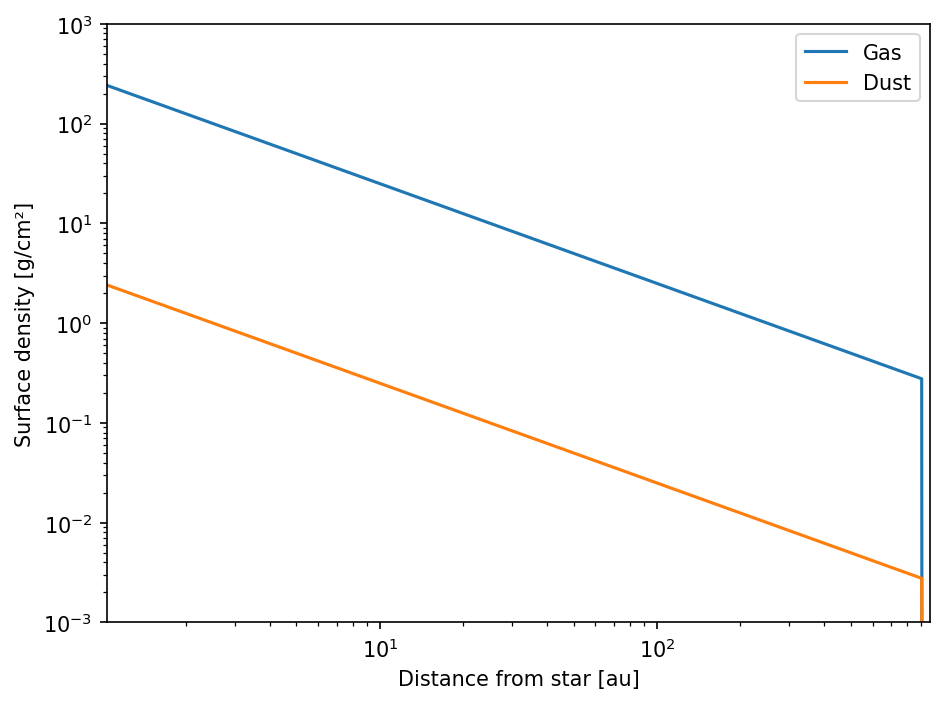

In [11]:
fig, ax = plt.subplots()
ax.loglog(sim.grid.r/c.au, sim.gas.Sigma, label="Gas")
ax.loglog(sim.grid.r/c.au, sim.dust.Sigma.sum(-1), label="Dust")
ax.set_xlim(sim.grid.r.min()/c.au, sim.grid.r.max()/c.au)
ax.set_ylim(1.e-3, 1.e3)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
ax.legend()
fig.tight_layout()

However, you can see some deviation at the outer boundary. The reason for that is, that the default outer boundary of DustPy is the floor value. Since we have not specified the boundary condition before the initalization step, DustPy has used the default prescription.

To fix this, we set the outer boundary of gas and dust to `const_grad` and directly apply it with `.setboundary()`. This will assure that the gradient of $r\Sigma$ will be constant at the outer boundary.

In [12]:
sim.gas.boundary.outer.setcondition("const_grad")
sim.gas.boundary.outer.setboundary()
sim.dust.boundary.outer.setcondition("const_grad")
sim.dust.boundary.outer.setboundary()

We have now a power law until the outer boundary.

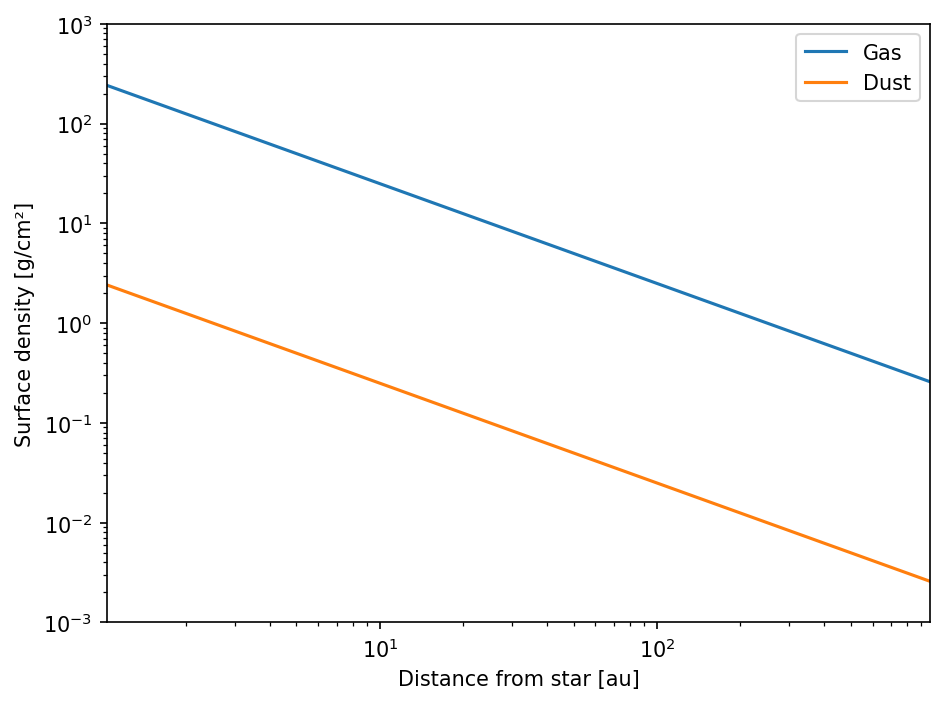

In [13]:
fig, ax = plt.subplots()
ax.loglog(sim.grid.r/c.au, sim.gas.Sigma, label="Gas")
ax.loglog(sim.grid.r/c.au, sim.dust.Sigma.sum(-1), label="Dust")
ax.set_xlim(sim.grid.r.min()/c.au, sim.grid.r.max()/c.au)
ax.set_ylim(1.e-3, 1.e3)
ax.set_xlabel("Distance from star [au]")
ax.set_ylabel("Surface density [g/cm²]")
ax.legend()
fig.tight_layout()

To turn off gas evolution we can simply remove the integration instruction of the gas.

In [14]:
sim.integrator.instructions

[Instruction (Dust: implicit 1st-order direct solver),
 Instruction (Gas: implicit 1st-order direct solver)]

This can be done by simply deleting the element from the list.

In [15]:
del(sim.integrator.instructions[1])

In [16]:
sim.integrator.instructions

[Instruction (Dust: implicit 1st-order direct solver)]

Note that this will only preventing DustPy from integrating the gas. All other fields of the gas will still be updated and can also be used by the dust. For example the gas velocity, which has an effect on dust accretion.  
If this is not intended, those fields have to be set to zero separately and their updater needs to be unset.

In [17]:
sim.gas.v.rad[...] = 0.
sim.gas.v.rad.updater = None

sim.gas.S.ext[...] = 0.
sim.gas.S.ext.updater = None
sim.gas.S.hyd[...] = 0.
sim.gas.S.hyd.updater = None
sim.gas.S.tot[...] = 0.
sim.gas.S.tot.updater = None

## Setting the fragmentation velocity

In the next step we want to add a temperature dependent fragmentation velocity. For this we have to provide a function that takes the simulation object as input and which returns the fragmentation velocity.  
We want to have a fragmentation velocity of $10\,\mathrm{m/s}$ outside the water ice line at $150\,\mathrm{K}$ and a fragentation velocity of $1\,\mathrm{m/s}$ else. Keep in mind the cgs units.

In [18]:
import numpy as np

In [19]:
def vfrag(sim):
    return np.where(sim.gas.T<=150., 1000., 100.)

This function now has to be added to the updater of the fragmentation velocity field.

In [20]:
sim.dust.v.frag.updater = vfrag

If we plot the fragmentation velocity and the temperature we notice that the fragmentation velocity does not show a transition at the desired temperature.

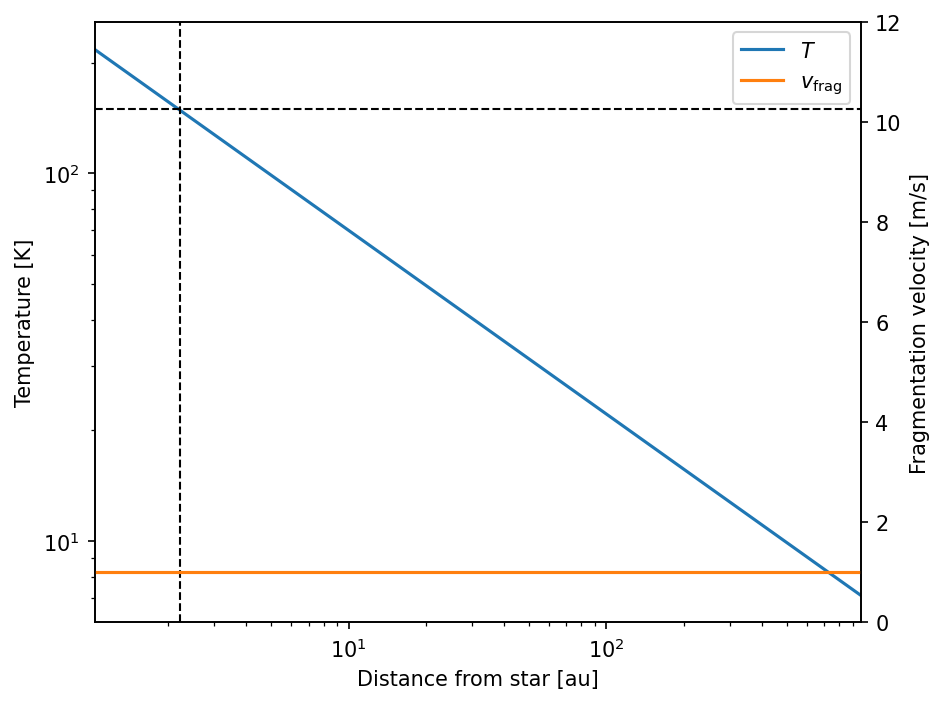

In [21]:
fig, axl = plt.subplots()
axr = axl.twinx()
axl.loglog(sim.grid.r/c.au, sim.gas.T, c="C0", label="$T$")
axl.axhline(150., color="black", lw=1, ls="--")
axl.axvline(sim.grid.r[np.abs(sim.gas.T-150.).argmin()]/c.au, color="black", lw=1, ls="--")
axl.plot(0., 0., c="C1", label="$v_\mathrm{frag}$")
axr.semilogx(sim.grid.r/c.au, sim.dust.v.frag/100., c="C1")
axl.set_xlabel("Distance from star [au]")
axl.set_ylabel("Temperature [K]")
axr.set_ylabel("Fragmentation velocity [m/s]")
axl.set_xlim(sim.grid.r.min()/c.au, sim.grid.r.max()/c.au)
axr.set_ylim(0., 12.)
axl.legend()
fig.tight_layout()

The reason for that is that so far we only have told DustPy how to compute the fragmentation velocity, but we have not instructed it to do it already.  
We can do this by simply invoking the updater.

In [22]:
sim.dust.v.frag.update()

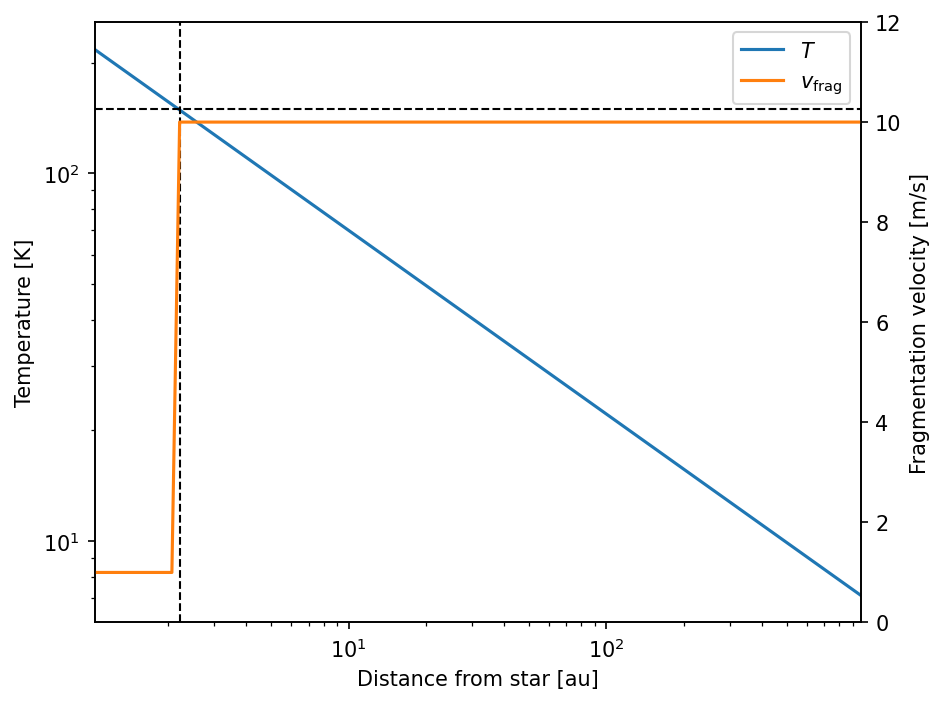

In [23]:
fig, axl = plt.subplots()
axr = axl.twinx()
axl.loglog(sim.grid.r/c.au, sim.gas.T, c="C0", label="$T$")
axl.axhline(150., color="black", lw=1, ls="--")
axl.axvline(sim.grid.r[np.abs(sim.gas.T-150.).argmin()]/c.au, color="black", lw=1, ls="--")
axl.plot(0., 0., c="C1", label="$v_\mathrm{frag}$")
axr.semilogx(sim.grid.r/c.au, sim.dust.v.frag/100., c="C1")
axl.set_xlabel("Distance from star [au]")
axl.set_ylabel("Temperature [K]")
axr.set_ylabel("Fragmentation velocity [m/s]")
axl.set_xlim(sim.grid.r.min()/c.au, sim.grid.r.max()/c.au)
axr.set_ylim(0., 12.)
axl.legend()
fig.tight_layout()

The fragmentation velocity has now the desired values.  
Note that we could have also simply assigned the desired values to the fragmentation velocity without taking the detour via the updater in this case, since the temperature is constant thoughout the simulation in the default model. However, implementing it via the updater makes sure that the fragmentation velocity also change in case we make some modifications to the temperature.

Before starting the simulation it is recommended to always update the entire simulation object to not only update the fields that have been modified, but also the field that depend on the modifications.

In [24]:
sim.update()

The simulation is now ready to go.  
We change the name of the output directory and adjust the desired snapshots.

In [25]:
sim.writer.datadir = "advanced"
sim.writer.overwrite = True

In [26]:
sim.t.snapshots = np.geomspace(1.e3, 1.e4, 11) * c.year

## Do-it-yourself

In [Pinilla et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017ApJ...845...68P/abstract) they implemented several ice lines with different transitions in the fragmentation velocity.

$
T =
\begin{cases}
 1\,\mathrm{m/s} & \text{for} \quad T > 150\,\mathrm{K} & \text{bare silicates} \\
 10\,\mathrm{m/s} & \text{for} \quad 150\,\mathrm{K} \geq T > 80\,\mathrm{K} & \text{water ice} \\
 7\,\mathrm{m/s} & \text{for} \quad 80\,\mathrm{K} \geq T > 44\,\mathrm{K} & \text{ammonia} \\
 1\,\mathrm{m/s} & \text{for} \quad 44\,\mathrm{K} \geq T & \text{carbon dioxide} 
\end{cases}
$

Try to implement this more complex behavior of the fragmentation velocity and run the simulation.

In [27]:
def vfrag_pinilla2017(sim):
    pass

In [28]:
sim.run()


DustPy v1.0.4

Documentation: https://stammler.github.io/dustpy/
PyPI:          https://pypi.org/project/dustpy/
GitHub:        https://github.com/stammler/dustpy/

Please cite Stammler & Birnstiel (2022).

Checking for mass conservation...

    - Sticking:
        max. rel. error:  2.81e-14
        for particle collision
            m[114] =  1.93e+04 g    with
            m[116] =  3.73e+04 g
    - Full fragmentation:
        max. rel. error:  4.44e-16
        for particle collision
            m[47] =  5.18e-06 g    with
            m[54] =  5.18e-05 g
    - Erosion:
        max. rel. error:  1.78e-15
        for particle collision
            m[110] =  5.18e+03 g    with
            m[118] =  7.20e+04 g

Writing file advanced/data0000.hdf5
Writing dump file advanced/frame.dmp
Writing file advanced/data0001.hdf5
Writing dump file advanced/frame.dmp
Writing file advanced/data0002.hdf5
Writing dump file advanced/frame.dmp
Writing file advanced/data0003.hdf5
Writing dump file advanced

In [29]:
from dustpy import plot

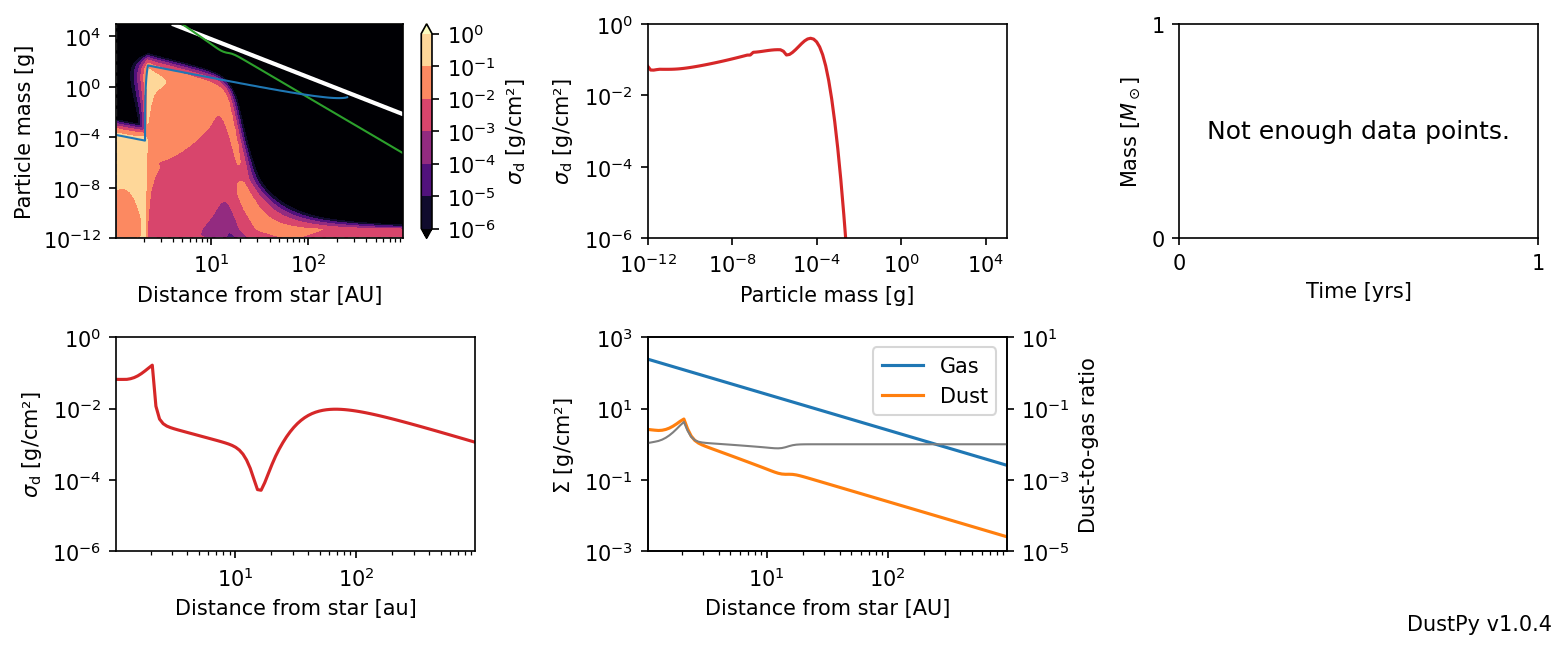

In [30]:
plot.panel(sim)